In [16]:
import numpy as np
import matplotlib.pyplot as plt
#matplotlib widget

In [17]:
mean_long = 35.00  #degrees
period = 2.75 # days
K = 1.0000 #m/s
e = 0.20
omega =  90.0 #degrees
Tref = 1.000

In [25]:
epochs = np.arange(0.00, 5.00, 0.001)



In [26]:



def kepler_RV_T0P(BJD0, mean_long, Period, K, e0, omega0, Omega0=0.0):
    # BJD0 is given as BJD-T0, where T0 is arbitrarily defined by the user
    # Tperi_ is substituted by _phase_, which is the phase of the orbit where
    #        BJD0+T0+phase*Period = Tperi
    # omega = argument of pericenter
    #

    omega = np.asarray(omega0, dtype=np.double)/180.*np.pi
    Omega = np.asarray(Omega0, dtype=np.double)/180.*np.pi
    e = np.asarray(e0, dtype=np.double)
    MeAn = 2. * np.pi * (1. + ((BJD0 / Period) + (mean_long/180.*np.pi - omega - Omega) / (2 * np.pi)) % 1.)
    #TODO check if the computation of mean anomaly is correct, i.e., include  Omega 
    #TODO semplify MeAn = [2*np.pi *(BJD0 / Period) + (mean_long/180.*np.pi - omega - Omega)] % (2 * np.pi)

    if abs(e0) < 1e-3:
        TrAn = np.asarray(MeAn, dtype=np.double)
        e = np.asarray(0., dtype=np.double)
    else:
        if e0 < 0.:
            e = -1 * e
            omega += np.pi

        # Eccentric Anomaly
        EccAn = kepler_E(MeAn, e)
        TrAn = 2. * np.arctan(np.sqrt((1.0 + e) / (1.0 - e)) * np.tan(EccAn / 2.0))

    rv = K * (np.cos(TrAn + omega) + e * np.cos(omega))

    return rv


def kepler_E(M_in, ecc):

    mx = np.atleast_1d(M_in) % (2. * np.pi)
    eccanom = np.zeros(np.size(mx), dtype=np.double)

    """
    #if ecc < 1e-10:
    #    return mx

    # equation 9a
    aux = 4.0 * ecc + 0.50
    alpha = (1.0 - ecc) / aux
    beta = mx / (2.0 * aux)

    # equation 9b
    ## the actual equation 9b is much much slower, but gives the same
    ## answer (probably because more refinement necessary)
    aux = np.sqrt(beta * beta + alpha * alpha * alpha)
    z = beta + aux
    sel_z = (z < 0.)

    z[sel_z] = beta[sel_z] + aux[sel_z]

    z = z ** (1. / 3.)

    s0 = mx * 0.
    sel_z = (abs(z) > 1e-8)
    s0[sel_z] = z - alpha / z

    s1 = s0 - (0.078 * s0 ** 5) / ((1.) + ecc)

    # first guess of e0
    e0 = mx + ecc * (3. * s1 - 4. * s1 ** 3.)

    # difference from first estimate of E
    e0_diff = e0 - ecc * np.sin(e0) - mx

    """

    # Using Fulton scheme
    k = 0.85

    e0 = mx + np.sign(np.sin(mx)) * k * ecc  # first guess at E
    # fiarr should go to zero when converges
    e0_diff = ( e0 - ecc * np.sin(e0) - mx)


    conv = 1.0e-12  # convergence criterion
    convd = np.where(np.abs(e0_diff) > conv)[0]  # which indices have not converged
    nd = len(convd)  # number of unconverged elements
    count = 0

    while nd > 0:  # while unconverged elements exist
        count += 1

        e0_conv = e0[convd]# just the unconverged elements ...

        se0 = np.sin(e0_conv)
        ce0 = np.cos(e0_conv)

        f = e0_conv - ecc * se0 - mx[convd]
        f1 = 1. - ecc * ce0
        f2 = ecc * se0
        f3 = ecc * ce0
        u1 = -f / f1
        u2 = -f / (f1 + 0.5 * f2 * u1)
        u3 = -f / (f1 + 0.5 * f2 * u2 + (1. / 6.) * f3 * u2 ** 2.)
        u4 = -f / (f1 + 0.5 * f2 * u3 + (1. / 6.) * f3 * u3 ** 2 - (1. / 24.) * f2 * u3 ** 3)

        e0_conv += u4

        e0[convd] = e0_conv
        e0_diff = e0 - ecc * np.sin( e0 ) - mx
        convd = np.abs(e0_diff) > conv  # test for convergence
        nd = np.sum(convd is True)


        #ecan_tmp = newton(f0_keplerE, ecan_tmp, fprime=f1_keplerE, args=(ecc, mx))
        #ecan_tmp = ecan_tmp % (2. * np.pi)
    ecan_tmp = e0 % (2. * np.pi)

    return ecan_tmp

In [86]:
def kepler_phase2Tc_Tref(Period, mean_long, e0=0., omega0=90., Omega0=0.0):
    # The closest Tcent after Tref is given back
    omega = omega0/180.*np.pi
    Omega = Omega0/180.*np.pi
    TrAn = np.pi / 2 - omega
    EccAn = 2. * np.arctan(np.sqrt((1.0 - e0) / (1.0 + e0)) * np.tan(TrAn / 2.0))
    MeAn = EccAn - e0 * np.sin(EccAn)
    return (MeAn - mean_long/180.*np.pi + omega + Omega) / (2 * np.pi) * Period % Period


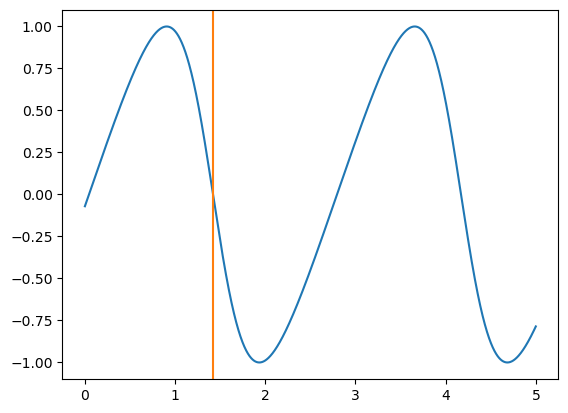

In [29]:
RV = kepler_RV_T0P(epochs-Tref, mean_long, period, K, e, omega)

Tcent = kepler_phase2Tc_Tref(period, mean_long, e0=0., omega0=90.)

plt.plot(epochs, RV)
plt.axvline(Tcent + Tref, c='C1')
plt.show()

In [35]:
def compute_epoch(Tref, Pref, TTs):

    epo = np.rint((TTs - Tref) / Pref)

    return epo

def true_anomaly_from_true_longitude(longn, argp):
    truel = (3*180.0)/2
    return (truel - longn - argp)%360.0

def ecc_anomaly_from_true_anomaly(true_anomaly, eccentricity):
    
    truea = np.deg2rad(true_anomaly)
    
    tan_hta = np.tan(0.5*truea)
    ecoeff = np.sqrt((1-eccentricity)/(1+eccentricity))
    eccanom = np.rad2deg(2*np.arctan(ecoeff*tan_hta))%360.0

    return eccanom

def mean_anomaly_from_eccentric_anomaly(ecc_anomaly, eccentricity):
    
    ecca = np.deg2rad(ecc_anomaly)
    meana = np.rad2deg(ecca - eccentricity*np.sin(ecca))

    return meana

def transit_time_from_mean_anomalies(t_e, P, meana_tc, meana_te):
    return t_e + (P/(2*np.pi))*np.deg2rad(meana_tc - meana_te)

def tc_from_keplerian_elements(t_e, P, ecc, argp, longn, meana):

    nu_tc = true_anomaly_from_true_longitude(longn, argp)
    ecca_tc = ecc_anomaly_from_true_anomaly(nu_tc, ecc)
    meana_tc = mean_anomaly_from_eccentric_anomaly(ecca_tc, ecc)

    tc = transit_time_from_mean_anomalies(t_e, P, meana_tc, meana)
    
    return tc

def compute_delta_time(obsT0, Tc, P):

    dt = obsT0 - Tc
    idtp = np.rint(dt/P)
    dtp = dt - idtp*P

    return dt, idtp, dtp

def transit_times_from_keplerian_elements(t_e, P, ecc, argp, longn, meana, obs_t0):

    tc = tc_from_keplerian_elements(t_e, P, ecc, argp, longn, meana)
    
    obs_epo = compute_epoch(tc, P, obs_t0)
    tnew_list = np.zeros(len(obs_epo))
    dt_list = np.zeros(len(obs_epo))
    idtp_list = np.zeros(len(obs_epo))
    dtp_list = np.zeros(len(obs_epo))
    for iepo, epo in enumerate(obs_epo):
        tnew = tc + epo*P
        dt, idtp, dtp = compute_delta_time(obs_t0[iepo], tnew, P)
        dt_list[iepo] = dt
        idtp_list[iepo] = idtp
        dtp_list[iepo] = dtp

    return tc, tnew_list, dt_list, idtp_list, dtp_list

def transit_time_close_to_tepoch(t_e, obs_t0):

    adt = np.abs(np.asarray(obs_t0) - t_e)
    idx_min = np.argmin(adt)
    tx = obs_t0[idx_min]

    return tx




In [36]:

#MeAn = 2. * np.pi * (1. + ((BJD0 / Period) + (mean_long/180.*np.pi - omega - Omega) / (2 * np.pi)) % 1.)


t_e = 2458657.0
obs_t0 = np.array([
    1658.73999,
    1662.81104,
    1666.88336,
    1670.95086,
    1675.01606,
    1679.07242,
    1731.94194,
    2037.94623,
    2042.00827,
    2046.07458,
    2050.14405,
    2054.21920,
    2058.29358
]) + 2457000.0

P_b = 4.074554
e_b = 0.052162
longn_b = 180.0
meana_b = 159.7
argp_b = 141.11


# Compute the transit times
print(f"longn + meana + argp = {(longn_b + meana_b + argp_b)%360.0:.5f}")
print(f"meana + argp         = {(meana_b + argp_b)%360.0:.5f}")
print(f"longn                = {longn_b:.5f}")
print(f"meana                = {meana_b:.5f}")
print(f"argp                 = {argp_b:.5f}")
tc_b, tnew_b, dt_b, idtp_b, dtp_b = transit_times_from_keplerian_elements(t_e, P_b, e_b, argp_b, longn_b, meana_b, obs_t0)
obs_epo = compute_epoch(tc_b, P_b, obs_t0)
print(f"Transit time computed = {tc_b:.5f} (t_epoch = {t_e:.5f})")
print(f"{'epo':>3s} ==> {'obs_t0':>15s} - {'tnew':>15s} = {'dt':>12s} days {'dt%P':8s} idtp test")
for iepo, epo in enumerate(obs_epo):
    tnew = tnew_b[iepo]
    dt = dt_b[iepo]
    idtp = idtp_b[iepo] #np.rint(dt/P_b)
    test = dtp_b[iepo] # dt - P_b*idtp
    print(f"{epo:>3.0f} ==> {obs_t0[iepo]:15.5f} - {tnew:15.5f} = {dt:+12.5f} days {dtp_b[iepo]:+8.5f} {idtp:+4.0f} {test:+.5f}")


longn + meana + argp = 120.81000
meana + argp         = 300.81000
longn                = 180.00000
meana                = 159.70000
argp                 = 141.11000
Transit time computed = 2458658.73994 (t_epoch = 2458657.00000)
epo ==>          obs_t0 -            tnew =           dt days dt%P     idtp test
  0 ==>   2458658.73999 -         0.00000 =     +0.00005 days +0.00005   +0 +0.00005
  1 ==>   2458662.81104 -         0.00000 =     -0.00345 days -0.00345   -0 -0.00345
  2 ==>   2458666.88336 -         0.00000 =     -0.00569 days -0.00569   -0 -0.00569
  3 ==>   2458670.95086 -         0.00000 =     -0.01274 days -0.01274   -0 -0.01274
  4 ==>   2458675.01606 -         0.00000 =     -0.02210 days -0.02210   -0 -0.02210
  5 ==>   2458679.07242 -         0.00000 =     -0.04029 days -0.04029   -0 -0.04029
 18 ==>   2458731.94194 -         0.00000 =     -0.13997 days -0.13997   -0 -0.13997
 93 ==>   2459037.94623 -         0.00000 =     +0.27277 days +0.27277   +0 +0.27277
 94 ==>   

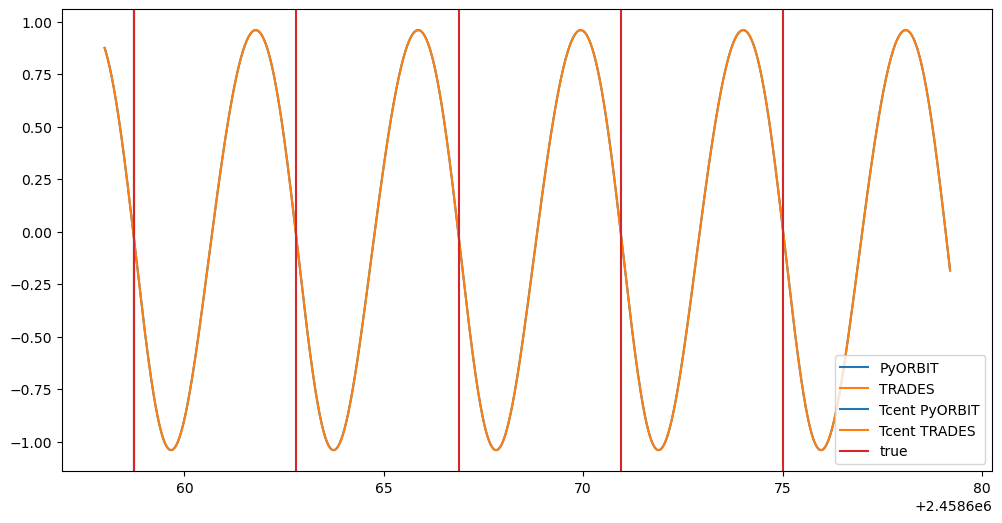

In [87]:
rv_epochs = np.arange(1658.0, 1679.2, 0.001) + 2457000.0
K=1.0 

mean_long_pyorbit = meana_b + argp_b #+ longn_b
rv_pyorbit = kepler_RV_T0P(rv_epochs-t_e, mean_long_pyorbit, P_b, K, e_b, argp_b)
Tcent_pyorbit = kepler_phase2Tc_Tref(P_b, mean_long_pyorbit, e_b, argp_b)

mean_long_trades = meana_b + argp_b + longn_b
rv_trades = kepler_RV_T0P(rv_epochs-t_e, mean_long_trades, P_b, K, e_b, argp_b, longn_b)
Tcent_trades = kepler_phase2Tc_Tref(P_b, mean_long_trades, e_b, argp_b, longn_b)

plt.figure(figsize=(12,6))
plt.plot(rv_epochs, rv_pyorbit, c='C0', label='PyORBIT')
plt.plot(rv_epochs, rv_trades, c='C1', label='TRADES')
plt.axvline(Tcent_pyorbit + t_e, c='C0', label='Tcent PyORBIT')
plt.axvline(Tcent_trades + t_e, c='C1', label='Tcent TRADES')

plt.axvline(obs_t0[0], c='C3', label='true')
for ii in range(1,5):
    plt.axvline(obs_t0[ii], c='C3')
plt.legend()
plt.show()

In [84]:
from time import time

omega0 = np.random.uniform(0, 360, 34)
omega0 = 45.64
deg2rad = np.pi/180.
time0 = time()
for ii in range(0,100):
    omega = np.asarray(omega0*deg2rad)
time1= time()
print(time1-time0)

time0 = time()
for ii in range(0,100):
    omega = np.asarray(np.deg2rad(omega0))
time1= time()
print(time1-time0)

0.0002377033233642578
0.0003592967987060547


In [78]:
aa = 345
bb =  np.deg2rad(aa).atleast_1d()
print(bb)

AttributeError: 'numpy.float64' object has no attribute 'atleast_1d'